### Importing the libraries

In [58]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### Setting path to dataset and device 

In [59]:
PATH = r"C:\Users\hp\Desktop\data"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# make sure my GPU is detected.
print(device)

cpu


### Data Augmentation and Normalization

In [84]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### Loading Dataset and creating Dataloader object

In [85]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(PATH, x),
                            data_transforms[x]) for x in ['Train', 'Valid']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], 
                                   batch_size=32,
                                   shuffle=True, 
                                ) for x in ['Train', 'Valid']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Valid']}

In [86]:
class_names = image_datasets['Train'].classes
print(class_names)

# ["adhirasam",

# "aloo_gobi",

# "aloo_matar",

# "aloo_methi",

# "aloo_shimla_mirch",

# "aloo_tikki"]

['adhirasam', 'aloo_gobi', 'aloo_matar', 'aloo_methi', 'aloo_shimla_mirch', 'aloo_tikki']


In [87]:
# create a function image show

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

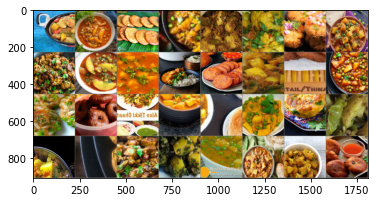

In [88]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [89]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Start training the model with Resnet18 weights

In [90]:
model_1 = models.resnet18(pretrained=True)
num_ftrs = model_1.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_1.fc = nn.Linear(num_ftrs, len(class_names))

model_1 = model_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_sgd = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = optim.Adam(model_1.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=7, gamma=0.1)

In [91]:
model_resnetft = train_model(model_1, criterion, optimizer_adam, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
Train Loss: 1.4228 Acc: 0.4750
Valid Loss: 5.5655 Acc: 0.4000

Epoch 1/14
----------
Train Loss: 1.1970 Acc: 0.6125
Valid Loss: 3.3085 Acc: 0.5667

Epoch 2/14
----------
Train Loss: 1.0239 Acc: 0.6500
Valid Loss: 3.0815 Acc: 0.5167

Epoch 3/14
----------
Train Loss: 0.8998 Acc: 0.6833
Valid Loss: 3.8717 Acc: 0.3833

Epoch 4/14
----------
Train Loss: 0.7473 Acc: 0.7375
Valid Loss: 3.8450 Acc: 0.5667

Epoch 5/14
----------
Train Loss: 0.5812 Acc: 0.8083
Valid Loss: 1.6404 Acc: 0.6500

Epoch 6/14
----------
Train Loss: 0.5193 Acc: 0.8167
Valid Loss: 1.3262 Acc: 0.6500

Epoch 7/14
----------
Train Loss: 0.3676 Acc: 0.8708
Valid Loss: 0.7394 Acc: 0.7833

Epoch 8/14
----------
Train Loss: 0.3848 Acc: 0.9042
Valid Loss: 0.5946 Acc: 0.8500

Epoch 9/14
----------
Train Loss: 0.3695 Acc: 0.8875
Valid Loss: 0.5328 Acc: 0.8500

Epoch 10/14
----------
Train Loss: 0.3092 Acc: 0.9083
Valid Loss: 0.5169 Acc: 0.8667

Epoch 11/14
----------
Train Loss: 0.2519 Acc: 0.9167
Valid Loss

### on valid

In [93]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
        
# Visualize model
visualize_model(model_1)

KeyError: 'Test'

<Figure size 432x288 with 0 Axes>